In [5]:
import pandas as pd
import os

import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall, accuracy
from sklearn.metrics import accuracy_score
import ipdb

In [3]:
pip install torchmetrics

     |████████████████████████████████| 332 kB 13.4 MB/s 


In [4]:
pip install ipdb

     |████████████████████████████████| 791 kB 16.1 MB/s 
     |████████████████████████████████| 374 kB 69.9 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=a031ce799f793d96c99f36e0610a282fc6ee5768f0a42f281df71754ba6e885c
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit

In [6]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 5.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=0b4c813dbd4cbe30671dd97f1f0cc32f9f0d215212afd0ca6093b4f8a3605e4a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [7]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [8]:
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file

In [9]:
!kaggle datasets download -d "clmentbisaillon/fake-and-real-news-dataset" --force 

100% 41.0M/41.0M [00:00<00:00, 77.3MB/s]
100% 41.0M/41.0M [00:00<00:00, 58.7MB/s]


In [10]:
!unzip fake-and-real-news-dataset.zip

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [493]:
true = pd.read_csv('True.csv')
fake_1 = pd.read_csv('Fake.csv')
news = pd.concat([true, fake])

In [12]:
news = pd.concat([true, fake])

In [13]:
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [14]:
def preprocess(text):
  return text.lower().split()

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
fake['subject'] = le.fit_transform(fake['subject'].values)

In [17]:
n_classes = len(set(list(fake['subject'])))
n_classes

6

In [494]:
def get_num_words(text):
  return len(text.split())

In [526]:
fake_1['num_words'] = fake_1['text'].apply(get_num_words)
mean = fake_1['num_words'].mean()
mean_2 = mean/2

In [513]:
first = fake_1[fake_1.num_words > mean_2].count()[1]
second = fake_1[(fake_1.num_words > mean_2) & (fake_1.num_words < mean)].count()[1] 
third = fake_1[(fake_1.num_words > mean) & (fake_1.num_words < (mean + mean_2))].count()[1] 
fourth = fake_1[fake_1.num_words > (mean + mean_2)].count()[1] 

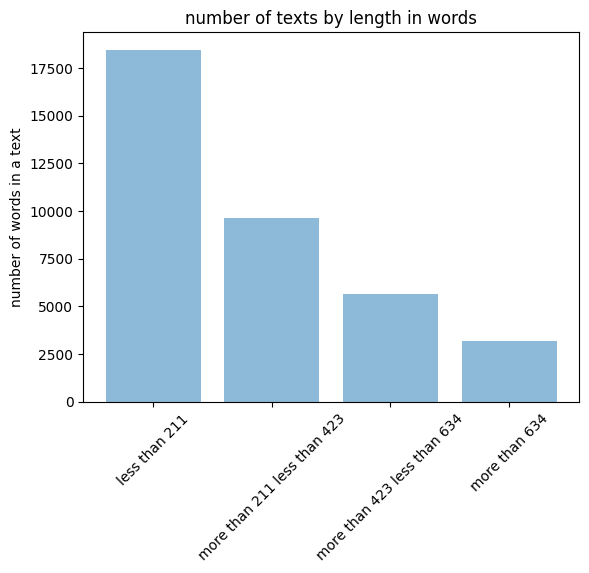

In [519]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('less than 211', 'more than 211 less than 423', 'more than 423 less than 634', 'more than 634')
performance = [first,second,third,fourth]

plt.bar(objects, performance, align='center', alpha=0.5)
plt.xticks(objects, objects, rotation=45)
plt.ylabel('number of texts')
plt.ylabel('number of words in a text')
plt.title('number of texts by length in words')

plt.show()

Бегло проанализировав данные узнаем, что у нас 6 классов; средняя длина текста -- 423 слова, есть совсем длинные тексты, но их мало, от их отрезков целесообразно будет избавиться, чтоб не перегружать колаб. Я обрежу все тексты до 634 символов (это значение [средняя длина + средняя длина/2]). Больше анализировать данные не буду, тк авторы предельно четко расписали то, как проходил препроцессинг -- и здесь я буду следовать за ними, обрабатывая тексты минимально (только приведу к нижнему регистру и токенизирую).

In [520]:
fake_1['text'] = [' '.join(x.split()[:634]) for x in list(fake_1['text'])]

In [19]:
vocab = Counter()
for text in fake['text']:
    vocab.update(preprocess(text)[:634])
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 233417


In [20]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('уникальных токенов, вcтретившихся больше 2 раз:', len(filtered_vocab))

уникальных токенов, вcтретившихся больше 2 раз: 74755


In [21]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [22]:
id2word = {i:word for word, i in word2id.items()}

In [23]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [24]:
import gensim
texts = fake.text.apply(preprocess).tolist()
w2v = gensim.models.Word2Vec(texts, size=100, window=5, min_count=5)

In [25]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      count += 1
      weights[i] = np.random.normal(0,0.1,100)

In [153]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['subject'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[symbol] for symbol in symbols if symbol in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      #y = F.one_hot(y.to(torch.int64) % 6).squeeze() 
      return padded_ids, y

In [305]:
tweets_data = shuffle(fake[['text','subject']])[:100000]
train_sentences, val_sentences = train_test_split(tweets_data, test_size=0.1)

In [313]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=64, drop_last=True)

In [314]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=64, drop_last=True)

Первая попытка построить совсем примитивную модель почти без возможности задавать гиперпараметры; сначала у меня оч долго вообще ничего не работало, поэтому оставлю эту модель как памятник своему долгому труду. Обучается она кстати нормально, лосс падает адекатно, качество тоже прикольно растет.

In [315]:
class CLSTM_0(nn.Module):
    
    def __init__(self, vocab_size, n_filters, embedding_dim, out_conv, hidden_lstm, out_lstm, n_classes, k):
        super().__init__()
        self.hidden_lstm = hidden_lstm
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=False)
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=out_conv, kernel_size=k, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(out_conv, hidden_lstm, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_lstm, out_features=6)

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        conv_out = self.relu(self.conv(embedded))
        conv_out = conv_out.transpose(1,2)
        output, (hidden, cell) = self.lstm(conv_out)
        lin_layer = self.linear(hidden.squeeze(0))
        return lin_layer

In [316]:
model_CLSTM = CLSTM_0(len(word2id), 3, 100, 64, 2, 64, n_classes, 1)
optimizer = optim.RMSprop(model_CLSTM.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model_CLSTM = model_CLSTM.to(DEVICE)
criterion = criterion.to(DEVICE)

In [471]:
def train(model, iterator, optimizer, criterion, print_v=True):
    epoch_loss = 0

    model.train()

    for i, (texts, ys) in enumerate(iterator): 
        optimizer.zero_grad() 
        ys =  ys.squeeze() 
        preds = model(texts)
        loss = criterion(preds, ys.long()) 
        loss.backward()
        optimizer.step() 
        epoch_loss += loss.item() 
        if print_v == True:
          if not (i + 1) % int(len(iterator)/5):
              print(f'Train loss: {epoch_loss/(i+1)}')      
    return model, epoch_loss / len(iterator)

In [472]:
import numpy as np 
def evaluate(model, iterator, criterion, print_v=True):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):  
            ys =  ys.squeeze()
            preds = model(texts)
            act_label = [np.argmax(x) for x in ys.cpu()] 
            pred_label = [np.argmax(x) for x in preds.cpu()]
            loss = criterion(preds, ys.long())  
            epoch_loss += loss.item()
            batch_metric = accuracy(preds, ys.long())
            epoch_metric += batch_metric
            if print_v == True:
              if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i+1)}, Val accuracy: {epoch_metric/(i+1)}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [300]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model_CLSTM, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_CLSTM, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_CLSTM, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 1.6964196797573206
Train loss: 1.6434330877029535
Train loss: 1.604884866512183
Train loss: 1.576069914933407
Train loss: 1.5555318525343231

Evaluating on train...
Val loss: 1.464610513412591, Val accuracy: 0.39441290497779846
Val loss: 1.4647969910592744, Val accuracy: 0.38731062412261963
Val loss: 1.4637996891532281, Val accuracy: 0.38825756311416626
Val loss: 1.4631322911291411, Val accuracy: 0.38725143671035767
Val loss: 1.4658294692183986, Val accuracy: 0.3858901262283325

Evaluating on test...
Val loss: 1.5180823632649012, Val accuracy: 0.3370535969734192
Val loss: 1.4921813096318925, Val accuracy: 0.3582589328289032
Val loss: 1.485594732420785, Val accuracy: 0.3683035671710968
Val loss: 1.4847573254789626, Val accuracy: 0.3699776828289032
Val loss: 1.4808319091796875, Val accuracy: 0.3812499940395355

starting Epoch 1
Training...
Train loss: 1.4489168615052195
Train loss: 1.4626223309473558
Train loss: 1.4550781532971546
Train loss: 1.4

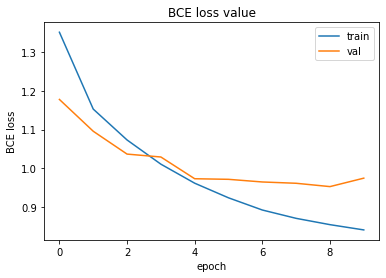

In [322]:
import matplotlib.pyplot as plt
plt.plot([x[1] for x in losses])
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

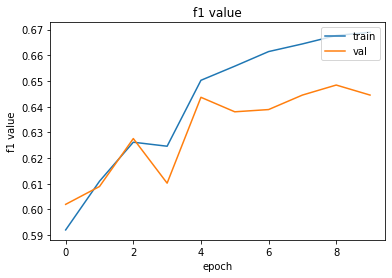

In [323]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

А вот и нормальная модель, где уже можно нормально задавать гиперпараметры. Сначала просто запущу ее с базовыми параметрами, прописанными в статье (они же указаны как дефолтные), потом проведу несколько экспериментов.

In [481]:
class CLSTM(nn.Module):
    def __init__(self, vocab_size, weights, embedding_dim=100, max_len=500, n_classes=6, filter_sizes=[2, 3, 4], num_filters=150, lstm_layers=1, lstm_hidden=150, 
                 perform_dropout_1=False, perform_dropout_2=False, dropout_rate_1=0.5, dropout_rate_2=0.5):

        super().__init__()

        self.perform_dropout_1 = perform_dropout_1
        self.perform_dropout_2 = perform_dropout_2
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_len = max_len
        self.filter_sizes = filter_sizes
        self.max_features = max_len - max(filter_sizes) + 1
        self.num_filters = num_filters
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(weights), freeze=False)
        windows = []
        self.dropout_1 = nn.Dropout(p=dropout_rate_1)
        for f in self.filter_sizes:
            conv = nn.Conv1d(in_channels=self.embedding_dim,
                             out_channels=self.num_filters,
                             kernel_size=f,
                             padding='valid')
            windows.append(conv)
        self.windows = nn.ModuleList(windows)
        self.relu = nn.ReLU()
        self.dropout_2 = nn.Dropout(p=dropout_rate_2)
        self.lstm = nn.LSTM(input_size=len(filter_sizes)* num_filters,
                            hidden_size=lstm_hidden, 
                            num_layers=lstm_layers,
                            batch_first=True) 
        self.linear = nn.Linear(lstm_hidden, n_classes)

    def forward(self, x):
        embeds = self.embeddings(x)
        embeds = embeds.transpose(1, 2)
        if self.perform_dropout_1:
            embeds = self.dropout_1(embeds)
        feature_maps = []
        for conv in self.windows:
            feature_map = self.relu(conv(embeds))[:, :, :self.max_features]
            feature_maps.append(feature_map)
        feature_maps = torch.cat(feature_maps, 1).transpose(1,2)
        output, (hidden, cell) = self.lstm(feature_maps)
        if self.perform_dropout_2:
            embedded = self.dropout_2(hidden)
        lin_layer = self.linear(hidden.squeeze(0))
        
        return lin_layer

In [477]:
model_w2v = CLSTM(len(word2id), weights=torch.FloatTensor(weights))
optimizer = optim.RMSprop(model_w2v.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model_w2v = model_w2v.to(DEVICE)
criterion = criterion.to(DEVICE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [478]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(10):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model_w2v, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model_w2v, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model_w2v, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 1.45773655537403
Train loss: 1.4046967526276906
Train loss: 1.3770359050143848
Train loss: 1.3682380318641663
Train loss: 1.34398309154944

Evaluating on train...
Val loss: 1.1222299897309505, Val accuracy: 0.5733901858329773
Val loss: 1.1180904543761052, Val accuracy: 0.5785984992980957
Val loss: 1.117017117112574, Val accuracy: 0.5774936676025391
Val loss: 1.1147731696114396, Val accuracy: 0.57421875
Val loss: 1.1165830357508226, Val accuracy: 0.572679877281189

Evaluating on test...
Val loss: 1.0773023962974548, Val accuracy: 0.6026785969734192
Val loss: 1.0818208030291967, Val accuracy: 0.5970982313156128
Val loss: 1.1103360170409793, Val accuracy: 0.5930059552192688
Val loss: 1.098157212138176, Val accuracy: 0.59765625
Val loss: 1.104300102165767, Val accuracy: 0.595089316368103

starting Epoch 1
Training...
Train loss: 1.1142954736044912
Train loss: 1.0826718739487908
Train loss: 1.0546672166597963
Train loss: 1.0466822001970175
Train los

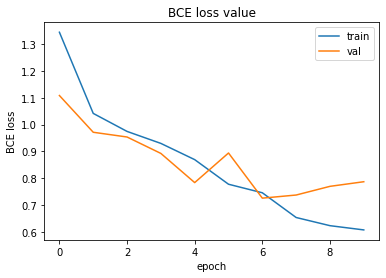

In [479]:
import matplotlib.pyplot as plt
plt.plot([x[1] for x in losses])
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

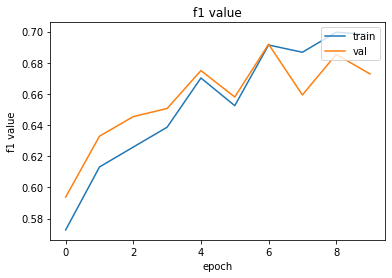

In [480]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Посмотрим, какой из дропаутов лучше применять (перед CNN или перед LSTM) и какую долю лучше выбрасыать (т.е. какой задавать параметр dropout_rate). Смотреть будем на графики.

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()



starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4



first drop True, second drop True
dropout_rate=0.1



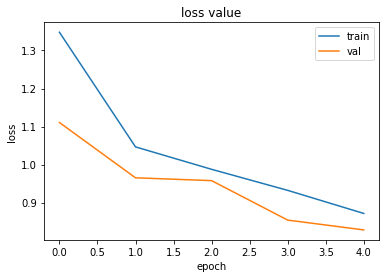

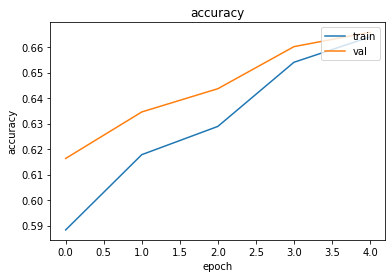






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4



first drop True, second drop False
dropout_rate=0.1



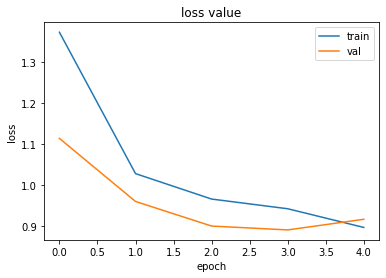

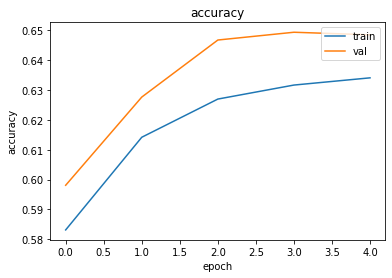






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4



first drop False, second drop True
dropout_rate=0.1



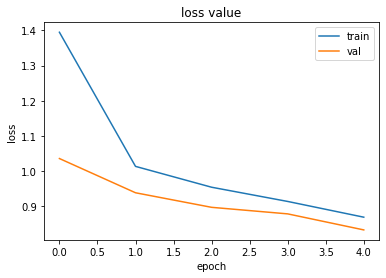

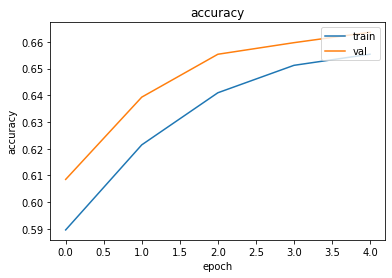






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4



first drop False, second drop False
dropout_rate=0.1



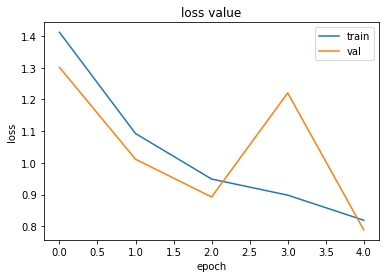

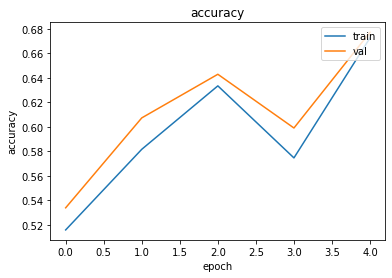






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4



first drop True, second drop True
dropout_rate=0.5



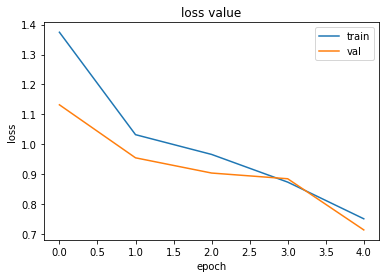

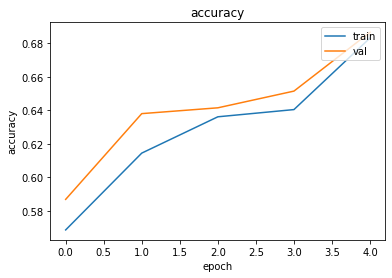






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4



first drop True, second drop False
dropout_rate=0.5



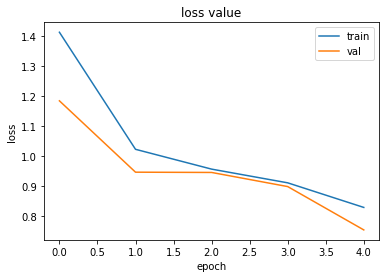

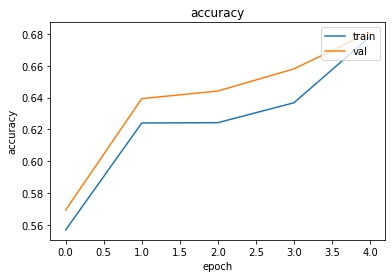






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4



first drop False, second drop True
dropout_rate=0.5



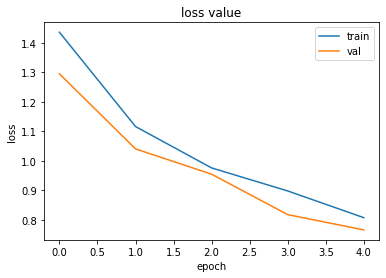

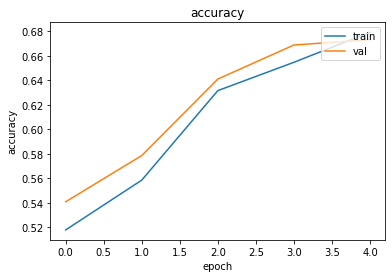






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4



first drop False, second drop False
dropout_rate=0.5



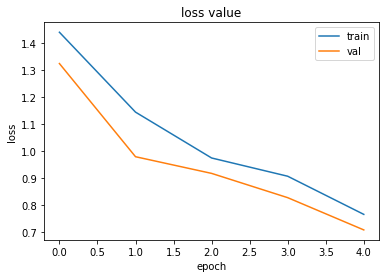

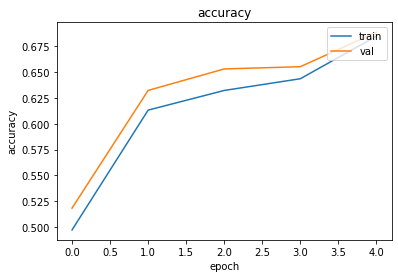

In [486]:
for dropout in tqdm([0.1, 0.5]):
  for first_drop in [True, False]:
    for second_drop in [True, False]:
            model = CLSTM(vocab_size=len(word2id),
                          weights=torch.FloatTensor(weights),
                          perform_dropout_1 = first_drop,
                          perform_dropout_2 = second_drop,
                          dropout_rate_1 = dropout,
                          dropout_rate_2 = dropout
                          )
            optimizer = optim.RMSprop(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()
            model = model.to(DEVICE)
            criterion = criterion.to(DEVICE)
            n_epochs = 5 
            i = 0
            losses = []
            f1s = []
            losses_eval = []
            f1s_eval = []
            for i in range(n_epochs):
              print(f'\nstarting Epoch {i}')
              #print('Training...')
              epoch_loss = train(model, train_iterator, optimizer, criterion, print_v=False)
              losses.append(epoch_loss)
              #print('\nEvaluating on train...')
              f1_on_train,_ = evaluate(model, train_iterator, criterion, print_v=False)
              f1s.append(f1_on_train)
              #print('\nEvaluating on test...')
              f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, print_v=False)
              losses_eval.append(epoch_loss_on_test)
              f1s_eval.append(f1_on_test)
            print(f'\n\n\nfirst drop {str(first_drop)}, second drop {str(second_drop)}')
            print(f'dropout_rate={dropout}\n')
            plt.plot([x[1] for x in losses])
            plt.plot(losses_eval)
            plt.title('loss value')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'val'], loc='upper right')
            plt.show()
            plt.plot(f1s)
            plt.plot(f1s_eval)
            plt.title('accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'val'], loc='upper right')
            plt.show()
            print('\n\n\n')

Любопытно, что результаты модели без дропаута вообще оказались ощутимо лучше, чем результаты модели с маленьким дропаутом (0.1), и соизмеримы по качеству с результатами модели с большим дропаутом (0.5). Кроме того, кажется, что применение одного большого дропаута работает примерно так же хорошо, как и применение двух; однако если выбирать, в какой именно момент лучше применять этот один дропаут, окажется, что лучше работает второй дропаут, т.е. после сверток (CNN слоя) и перед LSTM. Дропаут после эмбеддингов и перед свертками, т.е. первый показывает accuracy на 0.01 меньше, чем второй и чем оба дропаута.

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()



starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4
filter length=2



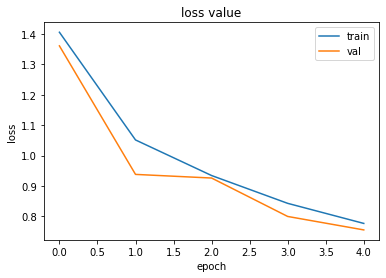

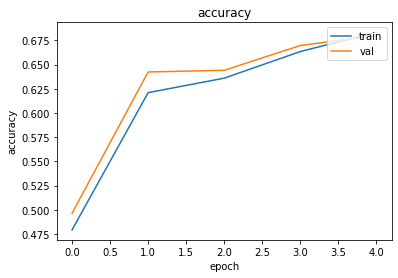






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4
filter length=3



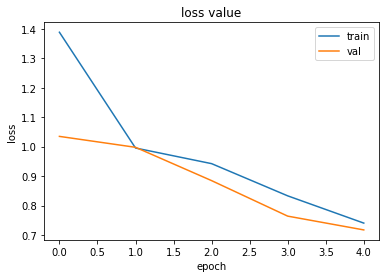

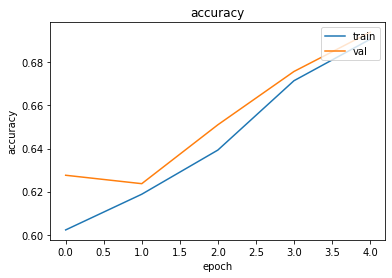






starting Epoch 0

starting Epoch 1

starting Epoch 2

starting Epoch 3

starting Epoch 4
filter length=4



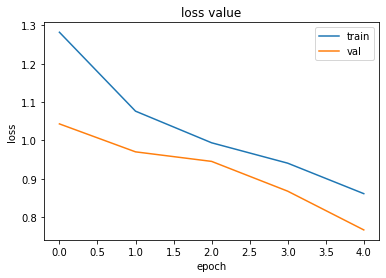

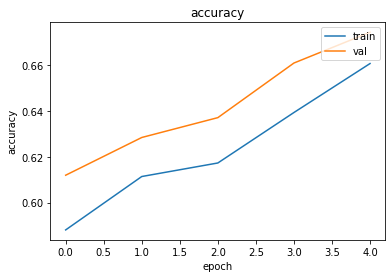

In [488]:
for filter_len in tqdm([2, 3, 4]):
    model = CLSTM(vocab_size=len(word2id),
                  weights=torch.FloatTensor(weights),
                  filter_sizes=[filter_len]
                  )
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)
    n_epochs = 5 
    i = 0
    losses = []
    f1s = []
    losses_eval = []
    f1s_eval = []
    for i in range(n_epochs):
      print(f'\nstarting Epoch {i}')
      #print('Training...')
      epoch_loss = train(model, train_iterator, optimizer, criterion, print_v=False)
      losses.append(epoch_loss)
      #print('\nEvaluating on train...')
      f1_on_train,_ = evaluate(model, train_iterator, criterion, print_v=False)
      f1s.append(f1_on_train)
      #print('\nEvaluating on test...')
      f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion, print_v=False)
      losses_eval.append(epoch_loss_on_test)
      f1s_eval.append(f1_on_test)
    print(f'filter length={filter_len}\n')
    plt.plot([x[1] for x in losses])
    plt.plot(losses_eval)
    plt.title('loss value')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    plt.plot(f1s)
    plt.plot(f1s_eval)
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    print('\n\n\n')

Здесь у нас, как и у авторов статьи, очевидно лучше работает размер окна 3. Размер окна 2 незначительно хуже, размер окна 4 явно слишком большой и сильно снижает accuracy модели.